In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from paths import mkl_data
#import requests # API library

import random
import time
import os

#from isoweek import Week

#import requests # API library

import numpy as np
import pandas as pd
import json
import re

import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuide, AutoNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam
from pyro.infer import Predictive



/tmp/ipykernel_5911/512193917.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/sandoar/miniconda3/envs/model/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def model3(obs, ids1, ids2, num_coaches):
    hyper_sigma = 1/8
    
    coach_mu_skill = 0
    coach_sigma_skill = 1

    # Sample skills for each coach using a plate for coaches
    with pyro.plate('coaches', num_coaches):
        coach_skills = pyro.sample("coach_skills", dist.Normal(coach_mu_skill, coach_sigma_skill))
    
    with pyro.plate('matches', obs.shape[0]):
        # Gather the skills for the competing coaches in each match
        coach1_skills = coach_skills[ids1]
        coach2_skills = coach_skills[ids2]

        # Sample performances for the coaches in each match
        coach1_perf = pyro.sample('coach1_perf', dist.Normal(coach1_skills, hyper_sigma))
        coach2_perf = pyro.sample('coach2_perf', dist.Normal(coach2_skills, hyper_sigma))

        # Compute the performance difference
        perf_diff = coach1_perf - coach2_perf

        # Sample the observed outcomes
        y = pyro.sample("y_coach1_win", dist.Normal(perf_diff, hyper_sigma), obs=obs)

    return y

In [3]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

# tror noget gik galt med at gætte størrelser med en autoguide, så fik chatgpt til at lave en guide til os.
import pyro
import pyro.distributions as dist
import torch

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
num_games = 12
obs = torch.ones(num_games)
id1 = torch.zeros(len(obs)).long()
id2 = torch.ones(len(obs)).long()
num_coaches = 2
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 431.788373708725
Step 100 : loss = 3.793013095855713
Step 200 : loss = 0.6848008632659912
Step 300 : loss = 2.4982762336730957
Step 400 : loss = 1.844573974609375
Step 500 : loss = 2.1639552116394043
Step 600 : loss = 2.0673484802246094
Step 700 : loss = 1.8288891315460205
Step 800 : loss = -0.5101046562194824
Step 900 : loss = 1.0617084503173828
Step 1000 : loss = -0.4647197723388672
Step 1100 : loss = 2.6221370697021484
Step 1200 : loss = 3.539590835571289
Step 1300 : loss = 5.583215236663818
Step 1400 : loss = 0.8830721378326416
Step 1500 : loss = 3.189321517944336
Step 1600 : loss = 4.516306638717651
Step 1700 : loss = 4.495195508003235
Step 1800 : loss = 6.724966526031494
Step 1900 : loss = 1.636049509048462
Step 2000 : loss = 3.6446213722229004
Step 2100 : loss = 4.769115924835205
Step 2200 : loss = 5.721271276473999
Step 2300 : loss = 3.3238167762756348
Step 2400 : loss = 3.434852123260498
Step 2500 : loss = -1.6010370254516602
Step 2600 : loss = 0.30782556533813

In [4]:
from pyro.infer import Predictive

predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)


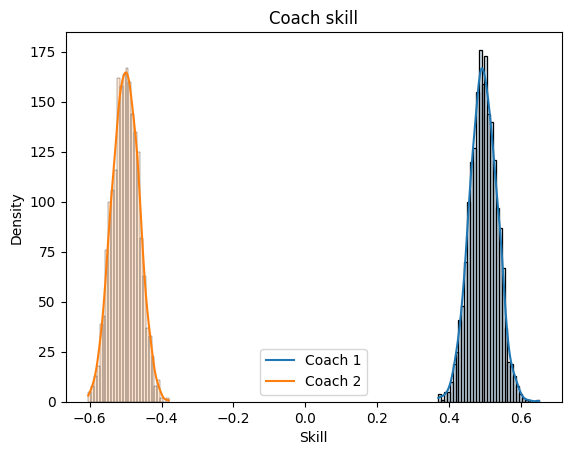

In [5]:
import seaborn as sns

labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()

# Try and make some fake data with multiple players where the player with the higher index always wins.

In [6]:
num_coaches = 6
# assuming round robin
num_games = 15

# round robin structure generated by chatgpt
id1 = [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 5]
id2 = [2, 3, 4, 5, 6, 3, 4, 5, 6, 4, 5, 6, 5, 6, 6]

id1 = torch.tensor(id1).long()
id1 = id1 - 1
id2 = torch.tensor(id2).long()
id2 = id2 - 1

obs = []
for i in range(num_games):
    if id1[i] < id2[i]:
        obs.append(-1)
    else:
        obs.append(1)

obs = torch.tensor(obs)

In [7]:
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

import pyro
import pyro.distributions as dist
import torch

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 479.537992477417
Step 100 : loss = 75.91675233840942
Step 200 : loss = 49.78711223602295
Step 300 : loss = 45.721728920936584
Step 400 : loss = 43.49094223976135
Step 500 : loss = 47.070322155952454
Step 600 : loss = 53.87869644165039
Step 700 : loss = 50.854742765426636
Step 800 : loss = 43.07656002044678
Step 900 : loss = 46.94941520690918
Step 1000 : loss = 50.0776172876358
Step 1100 : loss = 45.97532558441162
Step 1200 : loss = 50.21161091327667
Step 1300 : loss = 47.32425355911255
Step 1400 : loss = 48.597193241119385
Step 1500 : loss = 44.33949100971222
Step 1600 : loss = 51.374388456344604
Step 1700 : loss = 44.79090118408203
Step 1800 : loss = 44.13830065727234
Step 1900 : loss = 48.83060026168823
Step 2000 : loss = 47.06732523441315
Step 2100 : loss = 51.127565741539
Step 2200 : loss = 41.98597848415375
Step 2300 : loss = 46.448755621910095
Step 2400 : loss = 46.625877380371094
Step 2500 : loss = 48.720064640045166
Step 2600 : loss = 49.98795008659363
Step 2700

In [8]:
from pyro.infer import Predictive

predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

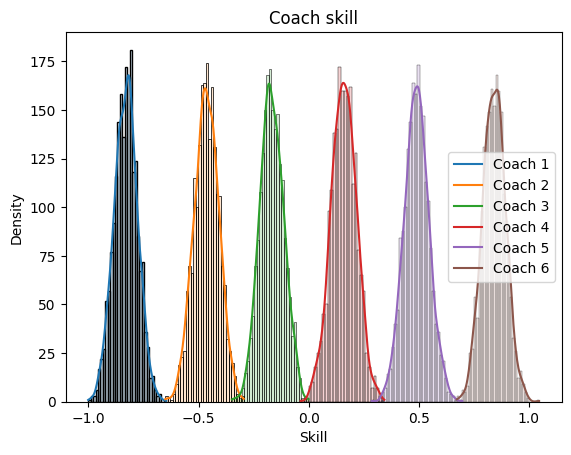

In [9]:
labels = []
for i in range(num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


# Try training on real data

In [10]:
# read and format data
df = pd.read_csv('../data/X_train.csv')

print(df.head())

# make a list of unique coaches
coaches1 = df['team1_coach_id']
coaches2 = df['team2_coach_id']
unique_coaches = pd.concat([coaches1, coaches2]).unique()

num_coaches = len(unique_coaches)

coach_winrates = np.zeros(num_coaches)
coach_num_matches = np.zeros(num_coaches)

for id, coach_id in enumerate(unique_coaches):
    coach1_df = df[df['team1_coach_id'] == coach_id]

    coach_winrates[id] += 0.5 * (coach1_df["team1_win"] == 0).sum()
    coach_winrates[id] += (coach1_df["team1_win"] == 1).sum()

    coach2_df = df[df['team2_coach_id'] == coach_id]
    coach_winrates[id] += 0.5 * (coach1_df["team2_win"] == 0).sum()
    coach_winrates[id] += (coach2_df["team2_win"] == 1).sum()

    coach_winrates[id] = coach_winrates[id] / (len(coach1_df) + len(coach2_df))
    coach_num_matches[id] = len(coach1_df) + len(coach2_df)

sort_variable = coach_num_matches

sorted_coaches = unique_coaches[np.argsort(sort_variable)[::-1]]
sorted_winrates = coach_winrates[np.argsort(sort_variable)[::-1]]
sorted_num_matches = coach_num_matches[np.argsort(sort_variable)[::-1]]

coach_dict = {coach: i for i, coach in enumerate(sorted_coaches)}

# make variables for the model sorted by winrate
id1 = torch.tensor(coaches1.map(coach_dict).values).long()
id2 = torch.tensor(coaches2.map(coach_dict).values).long()

obs = torch.tensor(df['team1_win'].values)
num_games = len(obs)

    week_date match_time  team1_coach_id  team2_coach_id  team1_win  \
0  2021-09-06   02:44:43           18963          232851          1   
1  2021-09-06   03:29:47            2525          238007          0   
2  2021-09-06   03:35:05          223328          235664         -1   
3  2021-09-06   03:56:15          131680          124683          0   
4  2021-09-06   04:25:20          227743          223328          0   

   team2_win    team1_race_name     team2_race_name  
0         -1         Tomb Kings  Necromantic Horror  
1          0     Chaos Renegade           Black Orc  
2          1           High Elf   Imperial Nobility  
3          0  Imperial Nobility        Chaos Chosen  
4          0          Lizardmen            High Elf  


In [11]:
# train
pyro.clear_param_store()

optimizer = Adam({"lr": 0.01})
guide = AutoNormal(model3)

# tror noget gik galt med at gætte størrelser med en autoguide, så fik chatgpt til at lave en guide til os.
import pyro
import pyro.distributions as dist
import torch

svi = SVI(model3, guide, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi.step(obs, id1, id2, num_coaches)
    if step % 100 == 0:
        print(f"Step {step} : loss = {loss}")


Step 0 : loss = 1941095.0483398438
Step 100 : loss = 509511.80517578125
Step 200 : loss = 469803.783203125
Step 300 : loss = 460145.9655761719
Step 400 : loss = 457152.8251953125
Step 500 : loss = 455860.5078125
Step 600 : loss = 455547.0700683594
Step 700 : loss = 454642.5869140625
Step 800 : loss = 454615.7429199219
Step 900 : loss = 454644.4255371094
Step 1000 : loss = 454464.1611328125
Step 1100 : loss = 454671.03466796875
Step 1200 : loss = 454710.7626953125
Step 1300 : loss = 454451.2512207031
Step 1400 : loss = 454575.1904296875
Step 1500 : loss = 454225.3337402344
Step 1600 : loss = 454800.1103515625
Step 1700 : loss = 454568.5380859375
Step 1800 : loss = 454577.60888671875
Step 1900 : loss = 454634.1115722656
Step 2000 : loss = 454548.6003417969
Step 2100 : loss = 454431.72412109375
Step 2200 : loss = 454761.4638671875
Step 2300 : loss = 454396.9562988281
Step 2400 : loss = 454514.8623046875
Step 2500 : loss = 454284.7570800781
Step 2600 : loss = 454539.6306152344
Step 2700 : 

In [12]:
from pyro.infer import Predictive

predictive = Predictive(model3, guide=guide, num_samples=2000)

samples = predictive(obs,id1, id2, num_coaches)

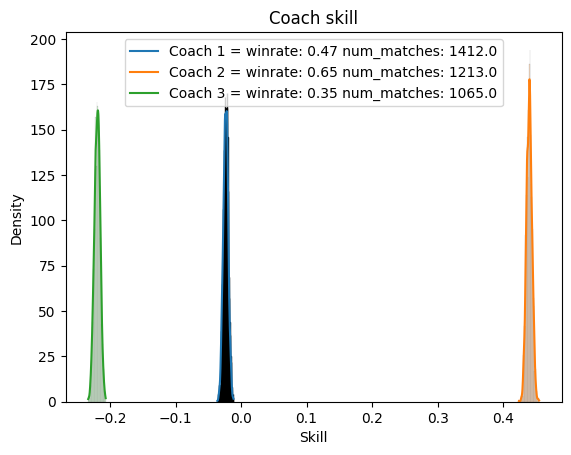

In [13]:
labels = []
for i in range(3):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


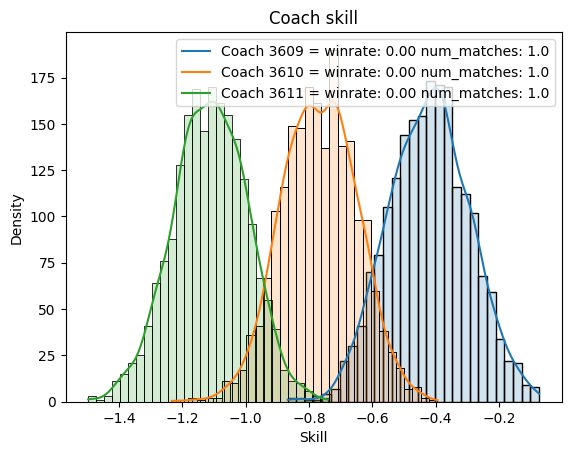

In [16]:
labels = []
for i in range(num_coaches-3, num_coaches):
    sns.histplot(samples["coach_skills"].detach().squeeze()[:,i], kde=True, alpha=0.2)
    labels.append(f"Coach {i+1} = winrate: {sorted_winrates[i]:.2f} num_matches: {sorted_num_matches[i]}")
    
plt.legend(labels)
plt.xlabel("Skill")
plt.ylabel("Density")
plt.title("Coach skill")
plt.show()


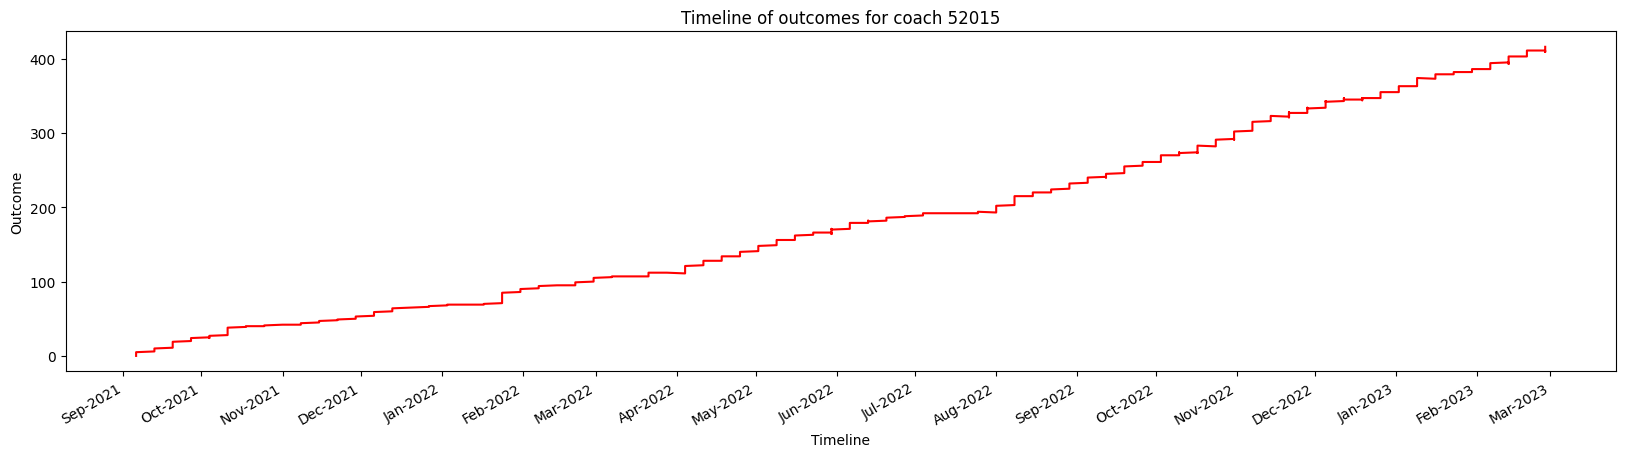

In [15]:
import matplotlib.dates as mdates

df = pd.read_csv('../data/X_train.csv')

# code for plotting the timeline of a coach
coach_index = 3
coach_id = sorted_coaches[coach_index]

mask = df['team2_coach_id'] == coach_id
df.loc[mask, 'team2_win'] *= -1
df.loc[mask, 'team1_win'] *= -1

coach1_df = df[df['team1_coach_id'] == coach_id].copy()
coach2_df = df[df['team2_coach_id'] == coach_id].copy()

coach_df = pd.concat([coach1_df, coach2_df])
coach_df['week_date'] = pd.to_datetime(coach_df['week_date'])
coach_df = coach_df.sort_values(by='week_date')

# plot the timeline of outcomes for the given coach
plt.figure(figsize=(20, 5))
plt.plot(coach_df['week_date'], np.cumsum(coach_df['team1_win']), 'r')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # 'Month-Year' format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # set locator to month
plt.gcf().autofmt_xdate()  # autoformat the x-axis date
plt.xlabel("Timeline")
plt.ylabel("Outcome")
plt.title(f"Timeline of outcomes for coach {coach_id}")
plt.show()
